In [1]:
from typing import Union
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter as smooth
from sklearn.preprocessing import StandardScaler as Scaler

from scipy.stats import mannwhitneyu as mnu
from scipy.stats import wilcoxon

from sklearn.metrics.pairwise import cosine_similarity as cosine
from scipy.stats import kendalltau as kendall

from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler as scaler

import statsmodels.api as sm

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')


# Definitions

In [2]:
def movavg(input, win=[], step=[]):
    '''
    Args:
        input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        win:   size of the window for moving averge
        step:  step size for moving forward
    Returns:
        output:     matrix of output data, with shape (Neurons,Stimuli,Timepoints),
                    where Timepoints are following the moving average process
        timestamps: (N,) vector of timepoints, corresponding to the output data, 
                    where N is the number of timepoints following the moving average process
    '''

    if not win: win = input.shape[2] // 25
    if not step: step = win // 10
    
    bins = [np.arange(0,input.shape[2]-win+1,step), 
            np.arange(win, input.shape[2]+1, step)]
    
    nbins = np.array(bins).shape[1]
    output = np.nan * np.zeros((input.shape[0], input.shape[1], nbins))

    timestamps = []
    counter_bin = 0
    for bin_st, bin_end in tqdm(zip(bins[0],bins[1])):
        timestamps.append(np.nanmean([bin_st, bin_end]))
        output[:,:,counter_bin] = np.nanmean(input[:,:,bin_st:bin_end], axis=2)
        counter_bin += 1

    return output, np.array(timestamps)


def m_plot(input_data, colors, error_method='sem', smooth_win=0, labels=[], plot_title='', timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:   (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        colors:       (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                      where N is the number of conditions. FaceAlpha in the scale=[0-255]
        error_method: variation metric ('sem' & 'std')
        smooth_win:   smoothing window
        
        labels:       (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:   title of the generated plot
        timepoints:   (N,) vaetor of timepoints
        figure_size:  two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    if not labels: labels=['']*len(input_data)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data[0].shape[1])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for i,Cond in enumerate(input_data):
        data_ave = smooth(np.nanmean(Cond, axis=0), smooth_win, axes=0)
        data_std = smooth(np.nanstd(Cond, axis=0), smooth_win, axes=0)
        
        if error_method=='sem':
            error_up  = data_ave + (data_std / np.sqrt(Cond.shape[0]))
            error_low = data_ave - (data_std / np.sqrt(Cond.shape[0]))
        elif error_method=='std':
            error_up  = data_ave + data_std
            error_low = data_ave - data_std

        plt.fill_between(timepoints, error_up, error_low, color=colors[i], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[i,:3], lw=3, label=labels[i])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)
    plt.tight_layout()


def categorizer(data_sample):
    if data_sample['defi']=='face_human':
        cat_num = 0
    elif data_sample['defi']=='face_monkey':
        cat_num = 1
    elif data_sample['defi']=='body_monkey':
        cat_num = 2
    elif data_sample['defi']=='body_human':
        cat_num = 3
    elif data_sample['defi']=='animal':
        cat_num = 4
    elif data_sample['defi']=='reptile':
        cat_num = 5
    elif data_sample['defi']=='fish':
        cat_num = 6
    elif data_sample['defi']=='bird':
        cat_num = 7
    elif data_sample['defi']=='insect':
        cat_num = 8
    elif data_sample['defi']=='plant':
        cat_num = 9
    elif data_sample['defi']=='fruit':
        cat_num = 10
    elif data_sample['defi']=='chair':
        cat_num = 11
    elif data_sample['defi']=='car':
        cat_num = 12
    elif data_sample['defi']=='house':
        cat_num = 13
    elif data_sample['defi']=='clock':
        cat_num = 14
    elif data_sample['defi']=='tool':
        cat_num = 15
    return cat_num


def reg_feat_neuron(reg_features, input_data):
    '''
    Args:
        reg_features: (N,M) ndarray of features or regressors or predictors for the 
                      regrsssion (Samples,Features)
        input_data:   (N,M,T) matrix of input data (Neurons,Samples,Timepoints)
    Retunrs:
        beta_values: (N,M,T) matrix of beta values (Features,Neurons,Timepoints)
        r2_valuesL:  (M,) vector of r2-scores (Timepoints,)
    '''
    r2_values, beta_values = [], []

    for iTime in tqdm(range(input_data.shape[2])):
        target = input_data[:, :, iTime].T

        pred, targ = [], []

        kf = KFold(n_splits=5, shuffle=True, random_state=15)
        mdl = Ridge(alpha=1.0, fit_intercept=True, random_state=15, solver='lsqr')
        # mdl = Ridge(alpha=1.0, fit_intercept=True, positive=True, random_state=15)
        # mdl = Ridge(alpha=1.0, fit_intercept=True, random_state=15)
        # mdl = LinearRegression(fit_intercept=True)

        for idx_trn, idx_tst in kf.split(reg_features):
            x_trn, x_tst = reg_features[idx_trn], reg_features[idx_tst]
            y_trn, y_tst = target[idx_trn], target[idx_tst]

            mdl.fit(x_trn, y_trn)
            pred.extend(mdl.predict(x_tst))
            targ.extend(y_tst)
    
        r2_values.append(r2_score(targ, pred))
        beta_values.append(mdl.coef_.T)

    return np.array(beta_values).transpose((1,2,0)), np.array(r2_values)


def reg_feat_every_neuron(reg_features, input_data):
    '''
    difference with previous function: looping over all neurons
    Args:
        reg_features: (N,M) ndarray of features or regressors or predictors for the 
                      regrsssion (Samples,Features)
        input_data:   (N,M,T) matrix of input data (Neurons,Samples,Timepoints)
    Retunrs:
        all_N_beta: (N,M,T) matrix of beta values (Features,Neurons,Timepoints)
        all_N_r2:   (M,N) vector of r2-scores (Neuron,Timepoints)
    '''

    all_N_r2, all_N_beta = [], []
    for iNeuron in tqdm(range(input_data.shape[0])):
        
        r2_values, beta_values = [], []
        for iTime in range(input_data.shape[2]):

            target = input_data[iNeuron, :, iTime].T
            tmp_pred, tmp_targ = [], []

            kf = KFold(n_splits=5, shuffle=True, random_state=15)
            # mdl = TweedieRegressor(power=0, alpha=0)
            mdl = TweedieRegressor(power=0)
            
            for idx_trn, idx_tst in kf.split(reg_features):
                x_trn, x_tst = reg_features[idx_trn], reg_features[idx_tst]
                y_trn, y_tst = target[idx_trn], target[idx_tst]

                mdl.fit(x_trn, y_trn)
                tmp_pred.extend(mdl.predict(x_tst))
                tmp_targ.extend(y_tst)

            r2_values.append(r2_score(tmp_targ, tmp_pred))
            beta_values.append(mdl.coef_.T)

        all_N_r2.append(np.array(r2_values))
        all_N_beta.append(np.array(beta_values))

    return np.array(all_N_beta).transpose((2,0,1)), np.array(all_N_r2)


def glm_LogReg(reg_features, input_data, target_reg):
    '''
    difference with previous function: looping over all neurons
    Args:
        reg_features: (N,M) ndarray of features or regressors or predictors for the 
                      regrsssion (Samples,Features), which does not include the "target_reg"
        input_data:   (N,M,T) matrix of input data (Neurons,Samples,Timepoints)
        target_reg:   (M,) array, containing the feature to be predicted (Samples,)
    Retunrs:
        all_N_beta: (N,M,T) matrix of beta values (Features,Neurons,Timepoints)
        all_N_r2:   (M,N) vector of r2-scores (Neuron,Timepoints)
    '''

    target_reg = np.array(target_reg)

    all_N_r2, all_N_beta = [], []
    for iNeuron in tqdm(range(input_data.shape[0])):
        
        r2_values, beta_values = [], []
        for iTime in range(input_data.shape[2]):

            reg = np.concatenate((input_data[iNeuron, :, iTime].reshape(input_data.shape[1],-1),
                                  np.array(reg_features).reshape(input_data.shape[1],-1)), axis=1)
            
            tmp_pred, tmp_targ = [], []

            kf = KFold(n_splits=5, shuffle=True, random_state=15)
            mdl = LogisticRegression()
            
            for idx_trn, idx_tst in kf.split(reg_features):
                x_trn, x_tst = reg[idx_trn], reg[idx_tst]
                y_trn, y_tst = target_reg[idx_trn], target_reg[idx_tst]

                mdl.fit(x_trn, y_trn)
                tmp_pred.extend(mdl.predict(x_tst))
                tmp_targ.extend(y_tst)

            r2_values.append(r2_score(tmp_targ, tmp_pred))
            beta_values.append(mdl.coef_.T)

        all_N_r2.append(np.array(r2_values))
        all_N_beta.append(np.array(beta_values))

    return np.nanmean(np.array(all_N_beta), axis=3).transpose((2,0,1)), np.array(all_N_r2)


def reg_feat_pop(reg_features, input_data):
    '''
    Args:
        reg_features: (N,M) ndarray of features or regressors or predictors for the 
                      regrsssion (Samples,Features)
        input_data:   (N,M,T) matrix of input data (Neurons,Samples,Timepoints)
    Retunrs:
        beta_values: (N,T) matrix of beta values (Features,Timepoints)
        r2_valuesL:  (M,) vector of r2-scores (Timepoints,)
    '''

    # input_data = np.linalg.norm(input_data, axis=0)
    input_data = np.nanmean(input_data, axis=0)
    r2_values, beta_values = [], []

    for iTime in range(input_data.shape[1]):
        target = input_data[:, iTime]

        pred, targ = [], []

        kf = KFold(n_splits=5, shuffle=True, random_state=15)
        # mdl = Ridge(alpha=1.0, fit_intercept=True, random_state=15, solver='lsqr')
        # mdl = Ridge(alpha=1.0, fit_intercept=True, positive=True, random_state=15)
        mdl = LinearRegression(fit_intercept=True)

        for idx_trn, idx_tst in kf.split(reg_features):
            x_trn, x_tst = reg_features[idx_trn], reg_features[idx_tst]
            y_trn, y_tst = target[idx_trn], target[idx_tst]

            mdl.fit(x_trn, y_trn)
            pred.extend(mdl.predict(x_tst))
            targ.extend(y_tst)
    
        r2_values.append(r2_score(targ, pred))
        beta_values.append(mdl.coef_.T)

    return np.array(beta_values).T, np.array(r2_values)


def FindResp(input_data, time_points, base_time_idx, resp_win=[50,300], onset_method=1):
    '''
    Args:
        input_data:    (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        time_points:   (M,) vector for values of the time axis
        base_time_idx: indices corresponding to the baseline
        resp_win:      two-item list of acceptable time window of response, in ms, with respect to time_points
        onset_method:  method to calculate onset
    Returns:
        val_peak:   value of the peak response
        time_peak:  time of the peak response
        time_onset: time of the onset response
        time_sol:   solution time, i.e., difference of peak and onset times (peak time - onset time)
        nan_count:  list containing number of nans for peak and onset times [number onset nans, number of peak nans]
    '''
    
    thr_std_base = 3
    thr_peak = .2

    val_peak, time_peak, time_onset = [], [], []
    for i,rep in enumerate(input_data):
        tmp_time_peak = time_points[rep.argmax()]

        tmp_base_ave = np.nanmean(rep[base_time_idx])
        tmp_base_std = np.nanstd(rep[base_time_idx])
        bools = rep > tmp_base_ave + (thr_std_base*tmp_base_std)
        if bools.sum()>0: tmp_time_onset = time_points[bools][0]
        else: tmp_time_onset = np.nan

        if (tmp_time_peak>resp_win[0]) & (tmp_time_peak<resp_win[1]) & (tmp_time_onset>resp_win[0]) & (tmp_time_onset<resp_win[1]):
            val_peak.append(rep.max())
            time_peak.append(time_points[rep.argmax()])
            time_onset.append(time_points[bools][0])
        else:
            val_peak.append(np.nan)
            time_peak.append(np.nan)
            time_onset.append(np.nan)

    time_sol = np.array(time_peak) - np.array(time_onset)

    nan_count = [(np.isnan(time_peak)).sum(), (np.isnan(time_onset)).sum()]

    return np.array(val_peak), np.array(time_peak), np.array(time_onset), time_sol, nan_count

def rand_idx_gen(cyles, cat_inds, stim_num, replacement=False):
    '''
    Args:
        cyles:       number repetitions or cycles
        cat_inds:    (N,) list of indices in each category/condition, where N is the number of categories/conditions,
                     and each item in the list is a np.array of indices for that category/condition.
        stim_num:    number of samples for each category/condition
        replacement: if True, sampling will be with replacement
    Returns:
        idx_rand: (N,M) np.array of the generated random indices, (cyles,cat_inds*stim_num)
    '''
    np.random.seed(15)
    idx_rand = []

    for iCycle in range(cyles):
        tmp_rand_tdx = []
        for i,iCat in enumerate(cat_inds):
            tmp_rand_tdx = np.concatenate((tmp_rand_tdx, iCat[np.random.choice(iCat.shape[0], stim_num, replace=replacement)]), axis=0)
        idx_rand.append(tmp_rand_tdx)

    return np.array(idx_rand).astype('int')



In [35]:
def glm_single(reg_features, input_data, lib='sm'):

    all_N_beta = []
    for iNeuron in tqdm(range(input_data.shape[0])):
        
        beta_values = []
        for iTime in range(input_data.shape[2]):
            target = input_data[iNeuron, :, iTime].T

            if lib=='sm':
                beta_values.append(sm.GLM(target, sm.add_constant(reg_features)).fit().params[1:])
                # beta_values.append(sm.GLM(target, sm.add_constant(reg_features)).fit().tvalues[1:])
            elif lib=='sk':
                beta_values.append(TweedieRegressor(power=0).fit(reg_features, target).coef_.T)

        all_N_beta.append(np.array(beta_values))
    return np.array(all_N_beta).transpose((2,0,1))


def glm_pop(reg_features, input_data, lib='sm'):

    input_data = np.nanmean(input_data, axis=0)

    all_beta = []
    for iTime in range(input_data.shape[1]):
        target = input_data[:, iTime]

        if lib=='sm':
            all_beta.append(sm.GLM(target, sm.add_constant(reg_features)).fit().params[1:])
        elif lib=='sk':
            all_beta.append(TweedieRegressor(power=0).fit(reg_features, target).coef_.T)

    return np.array(all_beta).T


def glm_single_sig(reg_features, input_data):

    all_N_beta   = np.zeros((reg_features.shape[1]+1, input_data.shape[0], input_data.shape[2])) * np.nan
    all_N_beta_z = np.copy(all_N_beta)

    for iNeuron in tqdm(range(input_data.shape[0])):
        for iTime in range(input_data.shape[2]):
            target = input_data[iNeuron, :, iTime].T
            
            mdl = sm.GLM(target, sm.add_constant(reg_features)).fit()
            tmp_idx = np.where(mdl.pvalues < 0.05)[0]
            all_N_beta[tmp_idx, iNeuron, iTime] = mdl.params[mdl.pvalues<.05]
            all_N_beta_z[tmp_idx, iNeuron, iTime] = mdl.tvalues[mdl.pvalues<.05]

    return all_N_beta[1:], all_N_beta_z[1:]


def glm_pop_sig(reg_features, input_data):

    input_data = np.nanmean(input_data, axis=0)

    all_beta   = np.zeros((reg_features.shape[1]+1, input_data.shape[1])) * np.nan
    all_beta_z = np.copy(all_beta)

    for iTime in range(input_data.shape[1]):
        target = input_data[:, iTime]

        mdl = sm.GLM(target, sm.add_constant(reg_features)).fit()
        tmp_idx = np.where(mdl.pvalues < 0.05)[0]
        all_beta[tmp_idx, iTime] = mdl.params[mdl.pvalues<.05]
        all_beta_z[tmp_idx, iTime] = mdl.tvalues[mdl.pvalues<.05]

    return all_beta[1:], all_beta_z[1:]

# Data

In [4]:
FigDir = '../Results/reg_figs/'

FileDir_IT = '../Data/Resp_IT.mat'
temp_file_IT = loadmat(FileDir_IT)

FileDir_PFC = '../Data/Resp_PFC.mat'
temp_file_PFC = loadmat(FileDir_PFC)

stim_info = pd.read_excel('../utils/stim_info.xlsx')
# stim_info.head(2)

vis_feat = pd.read_csv('../utils/vis_feature_py.csv')
# vis_feat.head()

# color
color_itc, color_pfc = [255, 187, 112, 80], [129, 104, 157, 80]
color_itc_n, color_pfc_n = [255/255, 187/255, 112/255, 80/255], [129/255, 104/255, 157/255, 80/255]

# parameters
SmoothWin = 20
step = 1
time_base = 80, #100

abs_level = 1
if abs_level == 1:
    stim_num = 50
    indc1 = np.arange(0,175,1)
    indc2 = np.arange(175,335,1)
elif abs_level == 2:
    stim_num = 20
    indc1 = np.arange(0,35,1)
    indc2 = np.arange(35,75,1)
ind_all = np.concatenate((indc1, indc2), axis=0)

resp_itc, time_stamps = movavg(temp_file_IT['resp_it'], SmoothWin, step)
resp_pfc, time_stamps = movavg(temp_file_PFC['resp_pfc'], SmoothWin, step)

time_stamps -= time_base

# population sub-sampling
cycel_num = 200
neuron_num = 50
idx_rand_itc = rand_idx_gen(cycel_num, [np.arange(resp_itc.shape[0])], neuron_num, replacement=False)
idx_rand_pfc = rand_idx_gen(cycel_num, [np.arange(resp_pfc.shape[0])], neuron_num, replacement=False)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [6]:
stim_info = pd.read_excel('../utils/stim_info.xlsx')
# stim_info.head(2)

vis_feat = pd.read_csv('../utils/vis_feature_py.csv')
# vis_feat.head()

ind_stim = np.concatenate((np.arange(2,180,6), [186,188,193,196,197], np.arange(200,500)), axis=0)

if 1:
    col_names = ['anim', 'face', 'body', 'huma', 'monk']
else:
    col_names = ['anim', 'face', 'body']
df = pd.DataFrame()
for col_name in col_names:
    df[col_name] = pd.get_dummies(stim_info[col_name].iloc[ind_stim], drop_first=True, dtype=int)

targ_cat = np.array(stim_info.iloc[ind_stim].apply(categorizer, axis=1)).reshape(df.shape[0],-1)

df = df.reset_index(drop=True)

df['circ'] = vis_feat['circ']
df['elong'] = vis_feat['elong']
df['spike'] = vis_feat['spike']
df['contrast'] = vis_feat['contrast']

if 0:
   df['pc1'] = vis_feat['pc1']
   df['pc2'] = vis_feat['pc2']

if 1:
   df['pc1'] = Scaler().fit_transform(np.array(vis_feat['pc1']).reshape(-1,1))
   df['pc2'] = Scaler().fit_transform(np.array(vis_feat['pc2']).reshape(-1,1))

if 1:
    MatFeatures_dir = '../utils/vis_feature_mat_NoBG.mat'
    mat_features = loadmat(MatFeatures_dir)
    # df['contrast'] = mat_features['Contrast'][0]
    df['luminance'] = mat_features['Luminance'][0]
    df['objArea'] = Scaler().fit_transform(np.array(vis_feat['objArea']).reshape(-1,1))
    # df['objArea'] = mat_features['objArea'][0]

conds = df.columns.to_list()

regressor = np.array(df)
print(regressor.shape)
df.head(2)


(335, 13)


,anim,face,body,huma,monk,circ,elong,spike,contrast,pc1,pc2,luminance,objArea
0,1,1,0,1,0,0.819194,0.261044,0.016938,0.855492,-0.054635,-0.054963,0.331287,0.808051
1,1,1,0,1,0,0.771879,0.267206,0.026045,0.879470,-0.054635,-0.054963,0.323011,0.736027


# Regression

In [36]:
method = 4
print(f'Method {method}')

if method == 1:    
    all_beta_itc, r2_itc = reg_feat_neuron(regressor, resp_itc)
    all_beta_pfc, r2_pfc = reg_feat_neuron(regressor, resp_pfc)
elif method == 2:
    all_beta_itc, r2_itc = reg_feat_every_neuron(regressor, resp_itc)
    all_beta_pfc, r2_pfc = reg_feat_every_neuron(regressor, resp_pfc)
elif method==3:
    all_beta_itc, r2_itc = glm_LogReg(regressor, resp_itc, targ_cat)
    all_beta_pfc, r2_pfc = glm_LogReg(regressor, resp_pfc, targ_cat)
elif method==4:
    all_beta_itc = glm_single(regressor, resp_itc)
    all_beta_pfc = glm_single(regressor, resp_pfc)
elif method==5:
    all_beta_itc, all_beta_itc_z = glm_single_sig(regressor, resp_itc)
    all_beta_pfc, all_beta_pfc_z = glm_single_sig(regressor, resp_pfc)

Method 4


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

In [37]:
if 0:
    plot_xlim = [-50,400]
    plot_ylim = [-.06,.06]
    smooth_win = 2

    plt.figure(figsize=(4,2))
    if method == 1:
        plt.plot(time_stamps, r2_itc, color=color_itc_n[:3], lw=3, label='ITC')
        plt.plot(time_stamps, r2_pfc, color=color_pfc_n[:3], lw=3, label='PFC')
    elif method in [2,3]:
        plt.plot(time_stamps, smooth(np.nanmean(r2_itc, axis=0), smooth_win), color=color_itc_n[:3], lw=3, label='ITC')
        plt.plot(time_stamps, smooth(np.nanmean(r2_pfc, axis=0), smooth_win), color=color_pfc_n[:3], lw=3, label='PFC')

    plt.xlim(plot_xlim)
    plt.xticks([0,100,200,300,400])
    # plt.ylim(plot_ylim)
    # plt.yticks([plot_ylim[0], 0, plot_ylim[1]])

    plt.fill_between([0, 80], [plt.ylim()[0], plt.ylim()[0]], [plt.ylim()[1], plt.ylim()[1]], color='gray', alpha=.2, edgecolor=None)

    plt.legend(frameon=False, fontsize=10)
    plt.xlabel('Time from stimulus onset (ms)')
    plt.ylabel('r2 score (au)')
    plt.tight_layout()

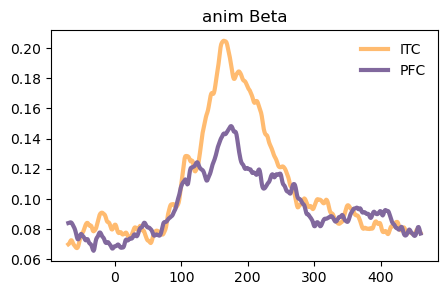

In [53]:
smooth_win = 1
beta_num = 0

beta_select_itc = smooth(abs(np.array(all_beta_itc[beta_num])), sigma=smooth_win, axes=1)
beta_select_pfc = smooth(abs(np.array(all_beta_pfc[beta_num])), sigma=smooth_win, axes=1)

plt.figure(figsize=(5,3))
plt.plot(time_stamps, smooth(np.nanmean(beta_select_itc, axis=0), smooth_win), color=color_itc_n[:3], lw=3, label='ITC')
plt.plot(time_stamps, smooth(np.nanmean(beta_select_pfc, axis=0), smooth_win), color=color_pfc_n[:3], lw=3, label='PFC')
plt.title(f'{conds[beta_num]} Beta')
plt.legend(frameon=False)

Text(25.09722222222222, 0.5, 'Beta Value (au)')

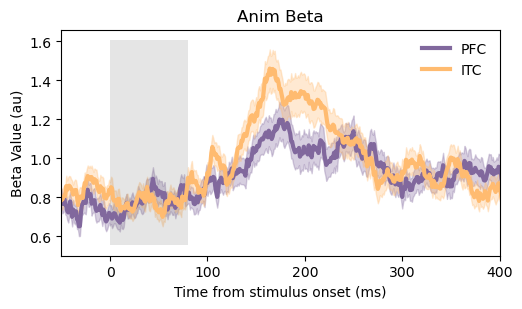

In [24]:
beta_num = 0
smooth_win = 0
myCond = conds[beta_num].capitalize()
beta_select_itc = smooth(abs(np.array(all_beta_itc[beta_num])), sigma=smooth_win, axes=1)
beta_select_pfc = smooth(abs(np.array(all_beta_pfc[beta_num])), sigma=smooth_win, axes=1)

plot_xlim = [-50,400]
figure_size=(5,3)

m_plot([beta_select_pfc, beta_select_itc], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel(f'Beta Value (au)')

MannwhitneyuResult(statistic=5377.0, pvalue=0.6361056227991393)


Text(0.5, 1.0, 'Peak Time')

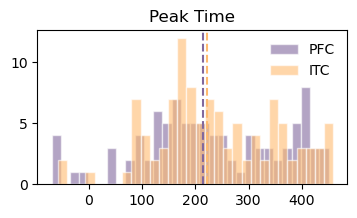

In [26]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(beta_select_itc, time_stamps, base_time_idx, resp_win=[-100,600])
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(beta_select_pfc, time_stamps, base_time_idx, resp_win=[-100,600])

figure_size=(4,2)

plt.figure(figsize=figure_size)

plot_num = 1
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    # plt.savefig(f'{FigDir}reg_beta_anim_stat.svg')
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(plot_title)

ITC neuron num = 78
PFC neuron num = 60
-----
Onset ITC = 114.5 -+ 51.13
Onset PFC = 109.0 -+ 49.6
Onset Mann-Whitney p = 0.5041905435055771
-----
Peak ITC = 162.0 -+ 45.68
Peak PFC = 148.0 -+ 53.67
Peak Mann-Whitney p = 0.09516035894769738
-----
Solution ITC = 25.5 -+ 46.29
Solution PFC = 18.0 -+ 40.11
Solution Mann-Whitney p = 0.41802003775060825


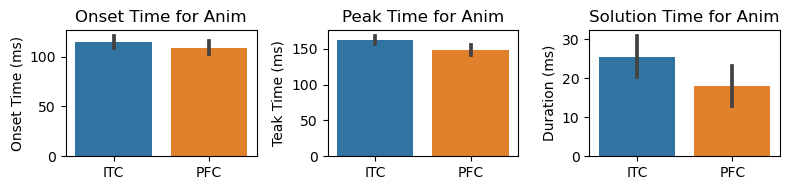

In [42]:
figure_size = np.array((4,1)) * 2
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)

plt_onset = sns.barplot(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator='median', errorbar='se')
# ax[0].set_ylim([90,130])
# ax[0].set_yticks([90,110,130])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator='median', errorbar='se')
# ax[1].set_ylim([140,200])
# ax[1].set_yticks([140,160,180,200])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator='median', errorbar='se')
# ax[2].set_ylim([0,60])
# ax[2].set_yticks([0,30,60])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'ITC neuron num = {(~np.isnan(onsetsss_itc)).sum()}')
print(f'PFC neuron num = {(~np.isnan(onsetsss_pfc)).sum()}')
print(f"-----")
print(f'Onset ITC = {np.nanmedian(onsetsss_itc).round(2)} -+ {np.nanstd(onsetsss_itc).round(2)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc).round(2)} -+ {np.nanstd(onsetsss_pfc).round(2)}')
print(f"Onset Mann-Whitney p = {mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc).round(2)} -+ {np.nanstd(peaksss_itc).round(2)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc).round(2)} -+ {np.nanstd(peaksss_pfc).round(2)}')
print(f"Peak Mann-Whitney p = {mnu(peaksss_itc, peaksss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc).round(2)} -+ {np.nanstd(solsss_itc).round(2)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc).round(2)} -+ {np.nanstd(solsss_pfc).round(2)}')
print(f"Solution Mann-Whitney p = {mnu(solsss_itc, solsss_pfc, nan_policy='omit')[1]}")

# plt.savefig(f'{FigDir}reg_beta_{myCond}_stat.svg')

Text(16.22222222222222, 0.5, 'Beta Value (au)')

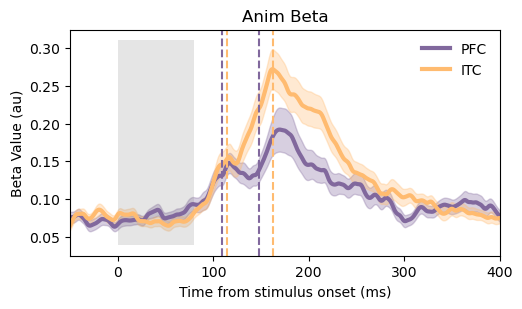

In [43]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.06]
figure_size = np.array((5,3)) * 1

beta_plot_itc = beta_select_itc[~np.isnan(peaksss_itc)]
beta_plot_pfc = beta_select_pfc[~np.isnan(peaksss_pfc)]

m_plot([beta_plot_pfc, beta_plot_itc], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

# plt.axvline(np.nanmean(peaksss_pfc), ls='--', color='b', alpha=1)
# plt.axvline(np.nanmean(peaksss_itc), ls='--', color='r', alpha=1)

plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Beta Value (au)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0], plot_ylim[1]])

# plt.savefig(f'{FigDir}reg_beta_{myCond}.svg')

MannwhitneyuResult(statistic=6436.0, pvalue=2.6173450951515663e-28)


Text(0.5, 1.0, 'Solution Time')

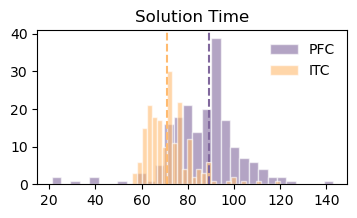

In [44]:
np.random.seed(15)
num_epoch = 200
rand_idx_itc, rand_idx_pfc = [], []
for i_ep in range(num_epoch):
    rand_idx_itc.append(np.random.choice((~np.isnan(peaksss_itc)).sum(),(~np.isnan(peaksss_itc)).sum()))
    rand_idx_pfc.append(np.random.choice((~np.isnan(peaksss_pfc)).sum(),(~np.isnan(peaksss_pfc)).sum()))

rands_itc, rands_pfc = [], []
for i_ep in range(num_epoch):
    rands_itc.append(np.nanmean(beta_plot_itc[rand_idx_itc[i_ep]], axis=0))
    rands_pfc.append(np.nanmean(beta_plot_pfc[rand_idx_pfc[i_ep]], axis=0))

base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(rands_itc, time_stamps, base_time_idx)
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(rands_pfc, time_stamps, base_time_idx)

figure_size=(4,2)

plt.figure(figsize=figure_size)

plot_num = 3
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    # plt.savefig(f'{FigDir}reg_beta_anim_stat.svg')
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(plot_title)

In [45]:
if 0:
    np.random.seed(15)
    num_epoch = 200
    rand_idx_itc, rand_idx_pfc = [], []
    for i_ep in range(num_epoch):
        rand_idx_itc.append(np.random.choice(137,137))
        rand_idx_pfc.append(np.random.choice(120,120))

    rands_itc, rands_pfc = [], []
    for i_ep in range(num_epoch):
        rands_itc.append(np.nanmean(beta_select_itc[rand_idx_itc[i_ep]], axis=0))
        rands_pfc.append(np.nanmean(beta_select_itc[rand_idx_pfc[i_ep]], axis=0))

    base_time_idx = (time_stamps>-50) & (time_stamps<50)
    _, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(rands_itc, time_stamps, base_time_idx)
    _, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(rands_pfc, time_stamps, base_time_idx)

    figure_size=(4,2)

    plt.figure(figsize=figure_size)

    plot_num = 1
    if plot_num==1:
        plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
        plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

        plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
        plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

        print(mnu(peaksss_itc, peaksss_pfc, nan_policy='omit'))
        plot_ylim = [0,8]
        plot_title = 'Peak Time'
        # plt.savefig(f'{FigDir}reg_beta_anim_stat.svg')
    elif plot_num==2:
        plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
        plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

        plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
        plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

        print(mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
        plot_ylim = [0,12]
        plot_title = 'Onset Time'
    elif plot_num==3:
        plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
        plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

        plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
        plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

        print(mnu(solsss_itc, solsss_pfc, nan_policy='omit'))
        plot_ylim = [0,25]
        plot_title = 'Solution Time'

    # plt.ylim(plot_ylim)
    # plt.yticks(plot_ylim)

    plt.legend(frameon=False)
    plt.title(plot_title)

In [46]:
figure_size = np.array((4,1)) * 2
estimator = 'median'
err_method = 'sd'
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)

plt_onset = sns.barplot
(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator=estimator, errorbar=err_method)
ax[0].set_ylim([60,120])
ax[0].set_yticks([60,80,100,120])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator=estimator, errorbar=err_method)
ax[1].set_ylim([80,200])
ax[1].set_yticks([80,120,160,200])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator=estimator, errorbar=err_method)
ax[2].set_ylim([0,120])
ax[2].set_yticks([0,40,80,120])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'ITC neuron num = {(~np.isnan(onsetsss_itc)).sum()}')
print(f'PFC neuron num = {(~np.isnan(onsetsss_pfc)).sum()}')
print(f"-----")
print(f'Onset ITC = {np.nanmedian(onsetsss_itc).round(2)} -+ {np.nanstd(onsetsss_itc).round(2)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc).round(2)} -+ {np.nanstd(onsetsss_pfc).round(2)}')
print(f"Onset Mann-Whitney p = {mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc).round(2)} -+ {np.nanstd(peaksss_itc).round(2)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc).round(2)} -+ {np.nanstd(peaksss_pfc).round(2)}')
print(f"Peak Mann-Whitney p = {mnu(peaksss_itc, peaksss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc).round(2)} -+ {np.nanstd(solsss_itc).round(2)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc).round(2)} -+ {np.nanstd(solsss_pfc).round(2)}')
print(f"Solution Mann-Whitney p = {mnu(solsss_itc, solsss_pfc, nan_policy='omit')[1]}")

# plt.savefig(f'{FigDir}reg_beta_{myCond}_stat.svg')

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (187168089.py, line 7)

Text(16.22222222222222, 0.5, 'Anim Beta Value')

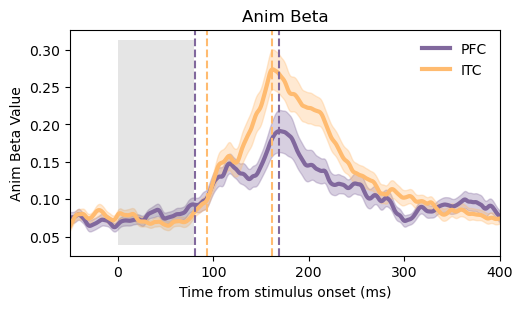

In [48]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [.05,.35]
figure_size = np.array((5,3)) * 1

beta_plot_itc = np.array(rands_itc)[~np.isnan(peaksss_itc)]
beta_plot_pfc = np.array(rands_pfc)[~np.isnan(peaksss_pfc)]

m_plot([beta_plot_pfc, beta_plot_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel(f'{myCond} Beta Value')
# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

# plt.savefig(f'{FigDir}reg_beta_{myCond}.svg')

Text(16.22222222222222, 0.5, 'Beta Value (au)')

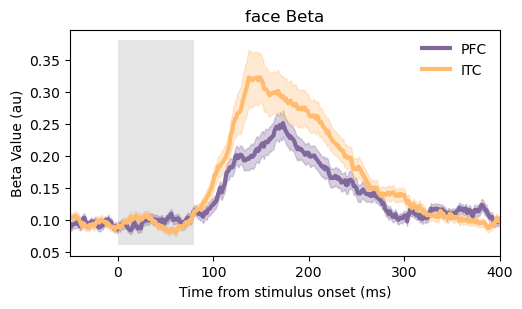

In [51]:
beta_num = 1
smooth_win = 0
myCond = conds[beta_num]
beta_select_itc = smooth(abs(np.array(all_beta_itc[beta_num])), sigma=smooth_win, axes=1)
beta_select_pfc = smooth(abs(np.array(all_beta_pfc[beta_num])), sigma=smooth_win, axes=1)

plot_xlim = [-50,400]
figure_size=(5,3)

m_plot([beta_select_pfc, beta_select_itc], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel(f'Beta Value (au)')

MannwhitneyuResult(statistic=3533.0, pvalue=0.6369168138234982)


Text(0.5, 1.0, 'Peak Time')

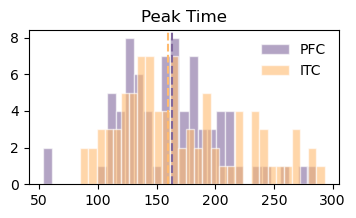

In [52]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(beta_select_itc, time_stamps, base_time_idx, resp_win=[50,300])
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(beta_select_pfc, time_stamps, base_time_idx, resp_win=[50,300])

figure_size = np.array((2,1)) * 2

plt.figure(figsize=figure_size)

plot_num = 1
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    # plt.savefig(f'{FigDir}reg_beta_anim_stat.svg')
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(mnu(solsss_itc[~np.isnan(solsss_itc)], solsss_pfc[~np.isnan(solsss_pfc)]))
    print(mnu(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(plot_title)

ITC neuron num = 88
PFC neuron num = 77
-----
Onset ITC = 108.5 -+ 45.5
Onset PFC = 112.0 -+ 40.7
Onset Mann-Whitney p = 0.48044730228226373
-----
Peak ITC = 159.5 -+ 51.83
Peak PFC = 163.0 -+ 43.15
Peak Mann-Whitney p = 0.6369168138234982
-----
Solution ITC = 31.5 -+ 50.79
Solution PFC = 45.0 -+ 43.44
Solution Mann-Whitney p = 0.9687299397006157


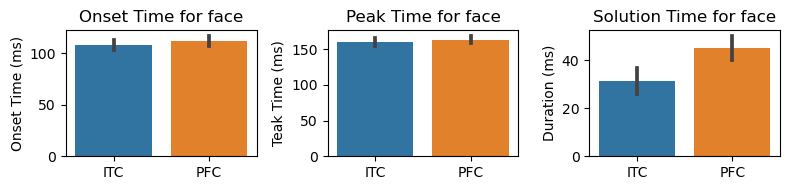

In [53]:
figure_size = np.array((4,1)) * 2
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)

plt_onset = sns.barplot(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator='median', errorbar='se')
# ax[0].set_ylim([90,130])
# ax[0].set_yticks([90,110,130])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator='median', errorbar='se')
# ax[1].set_ylim([140,180])
# ax[1].set_yticks([140,160,180])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator='median', errorbar='se')
# ax[2].set_ylim([0,60])
# ax[2].set_yticks([0,20,40,60])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'ITC neuron num = {(~np.isnan(onsetsss_itc)).sum()}')
print(f'PFC neuron num = {(~np.isnan(onsetsss_pfc)).sum()}')
print(f"-----")
print(f'Onset ITC = {np.nanmedian(onsetsss_itc).round(2)} -+ {np.nanstd(onsetsss_itc).round(2)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc).round(2)} -+ {np.nanstd(onsetsss_pfc).round(2)}')
print(f"Onset Mann-Whitney p = {mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc).round(2)} -+ {np.nanstd(peaksss_itc).round(2)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc).round(2)} -+ {np.nanstd(peaksss_pfc).round(2)}')
print(f"Peak Mann-Whitney p = {mnu(peaksss_itc, peaksss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc).round(2)} -+ {np.nanstd(solsss_itc).round(2)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc).round(2)} -+ {np.nanstd(solsss_pfc).round(2)}')
print(f"Solution Mann-Whitney p = {mnu(solsss_itc, solsss_pfc, nan_policy='omit')[1]}")

# plt.savefig(f'{FigDir}reg_beta_{myCond}_stat.svg')

Text(12.597222222222223, 0.5, 'Beta Value (au)')

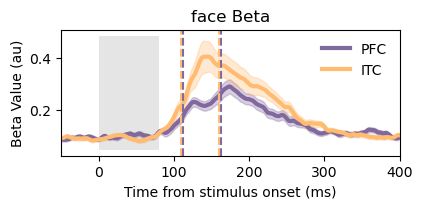

In [55]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.06]
figure_size = np.array((2,1)) * 2

beta_plot_itc = beta_select_itc[~np.isnan(peaksss_itc)]
beta_plot_pfc = beta_select_pfc[~np.isnan(peaksss_pfc)]

m_plot([beta_plot_pfc, beta_plot_itc], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Beta Value (au)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0], plot_ylim[1]])

# plt.savefig(f'{FigDir}reg_beta_{myCond}.svg')

In [57]:
np.random.seed(15)
num_epoch = 200
rand_idx_itc, rand_idx_pfc = [], []
for i_ep in range(num_epoch):
    rand_idx_itc.append(np.random.choice((~np.isnan(peaksss_itc)).sum(),(~np.isnan(peaksss_itc)).sum()))
    rand_idx_pfc.append(np.random.choice((~np.isnan(peaksss_pfc)).sum(),(~np.isnan(peaksss_pfc)).sum()))

rands_itc, rands_pfc = [], []
for i_ep in range(num_epoch):
    rands_itc.append(np.nanmean(beta_plot_itc[rand_idx_itc[i_ep]], axis=0))
    rands_pfc.append(np.nanmean(beta_plot_pfc[rand_idx_pfc[i_ep]], axis=0))

base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(rands_itc, time_stamps, base_time_idx)
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(rands_pfc, time_stamps, base_time_idx)

figure_size=(4,2)

plt.figure(figsize=figure_size)

plot_num = 3
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    # plt.savefig(f'{FigDir}reg_beta_anim_stat.svg')
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(plot_title)

IndexError: index 140 is out of bounds for axis 0 with size 88

ITC neuron num = 196
PFC neuron num = 194
-----
Onset ITC = 83.0 -+ 5.39
Onset PFC = 82.0 -+ 14.16
Onset Mann-Whitney p = 0.2929607653274099
-----
Peak ITC = 144.0 -+ 8.67
Peak PFC = 173.0 -+ 5.22
Peak Mann-Whitney p = 1.7309548754920273e-63
-----
Solution ITC = 59.0 -+ 9.18
Solution PFC = 91.0 -+ 15.02
Solution Mann-Whitney p = 1.2334828542008914e-52


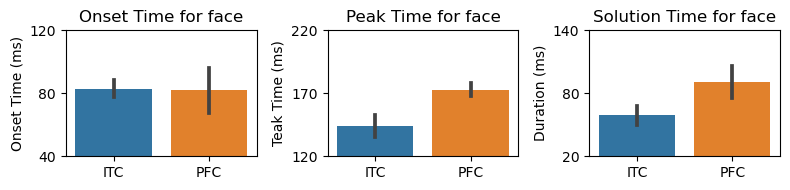

In [58]:
figure_size = np.array((4,1)) * 2
estimator = 'median'
err_method = 'sd'
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)

plt_onset = sns.barplot(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator=estimator, errorbar=err_method)
ax[0].set_ylim([40,120])
ax[0].set_yticks([40,80,120])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator=estimator, errorbar=err_method)
ax[1].set_ylim([120,220])
ax[1].set_yticks([120,170,220])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator=estimator, errorbar=err_method)
ax[2].set_ylim([20,140])
ax[2].set_yticks([20,80,140])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'ITC neuron num = {(~np.isnan(onsetsss_itc)).sum()}')
print(f'PFC neuron num = {(~np.isnan(onsetsss_pfc)).sum()}')
print(f"-----")
print(f'Onset ITC = {np.nanmedian(onsetsss_itc).round(2)} -+ {np.nanstd(onsetsss_itc).round(2)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc).round(2)} -+ {np.nanstd(onsetsss_pfc).round(2)}')
print(f"Onset Mann-Whitney p = {mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc).round(2)} -+ {np.nanstd(peaksss_itc).round(2)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc).round(2)} -+ {np.nanstd(peaksss_pfc).round(2)}')
print(f"Peak Mann-Whitney p = {mnu(peaksss_itc, peaksss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc).round(2)} -+ {np.nanstd(solsss_itc).round(2)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc).round(2)} -+ {np.nanstd(solsss_pfc).round(2)}')
print(f"Solution Mann-Whitney p = {mnu(solsss_itc, solsss_pfc, nan_policy='omit')[1]}")

# plt.savefig(f'{FigDir}reg_beta_{myCond}_stat.svg')

In [60]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [.05,.5]
figure_size = np.array((5,3)) * 1

beta_plot_itc = np.array(rands_itc)[~np.isnan(peaksss_itc)]
beta_plot_pfc = np.array(rands_pfc)[~np.isnan(peaksss_pfc)]

m_plot([beta_plot_pfc, beta_plot_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel(f'{myCond} Beta Value')
plt.ylim(plot_ylim)
plt.yticks(plot_ylim)

# plt.savefig(f'{FigDir}reg_beta_{myCond}.svg')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 200

Text(16.22222222222222, 0.5, 'Beta Value (au)')

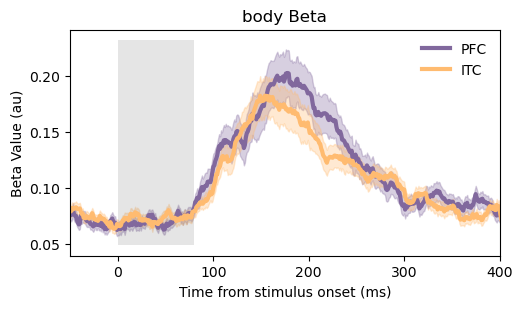

In [61]:
beta_num = 2
smooth_win = 0
myCond = conds[beta_num]
beta_select_itc = smooth(abs(np.array(all_beta_itc[beta_num])), sigma=smooth_win, axes=1)
beta_select_pfc = smooth(abs(np.array(all_beta_pfc[beta_num])), sigma=smooth_win, axes=1)

plot_xlim = [-50,400]
figure_size = np.array((5,3)) * 1

m_plot([beta_select_pfc, beta_select_itc], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel(f'Beta Value (au)')

MannwhitneyuResult(statistic=2457.0, pvalue=0.5248112616530098)


Text(0.5, 1.0, 'Peak Time')

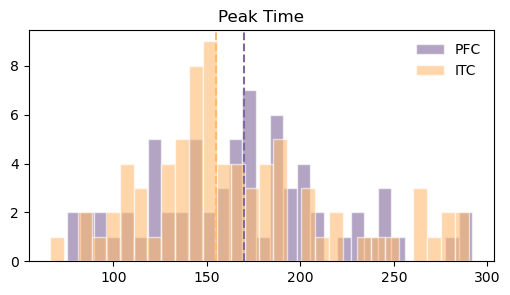

In [183]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(beta_select_itc, time_stamps, base_time_idx)
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(beta_select_pfc, time_stamps, base_time_idx)

figure_size=(6,3)

plt.figure(figsize=figure_size)

plot_num = 1
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    # plt.savefig(f'{FigDir}reg_beta_anim_stat.svg')
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(mnu(solsss_itc[~np.isnan(solsss_itc)], solsss_pfc[~np.isnan(solsss_pfc)]))
    print(mnu(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(plot_title)

ITC neuron num = 77
PFC neuron num = 68
-----
Onset ITC = 113.0 -+ 51.05
Onset PFC = 112.0 -+ 43.1
Onset Mann-Whitney p = 0.4769330834206664
-----
Peak ITC = 155.0 -+ 51.88
Peak PFC = 170.0 -+ 50.27
Peak Mann-Whitney p = 0.5248112616530098
-----
Solution ITC = 24.0 -+ 45.95
Solution PFC = 35.5 -+ 52.31
Solution Mann-Whitney p = 0.2177688766614263


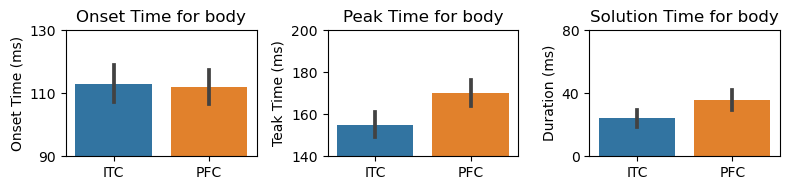

In [184]:
figure_size = np.array((4,1)) * 2
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)

plt_onset = sns.barplot(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator='median', errorbar='se')
ax[0].set_ylim([90,130])
ax[0].set_yticks([90,110,130])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator='median', errorbar='se')
ax[1].set_ylim([140,200])
ax[1].set_yticks([140,160,180,200])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator='median', errorbar='se')
ax[2].set_ylim([0,80])
ax[2].set_yticks([0,40,80])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'ITC neuron num = {(~np.isnan(onsetsss_itc)).sum()}')
print(f'PFC neuron num = {(~np.isnan(onsetsss_pfc)).sum()}')
print(f"-----")
print(f'Onset ITC = {np.nanmedian(onsetsss_itc).round(2)} -+ {np.nanstd(onsetsss_itc).round(2)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc).round(2)} -+ {np.nanstd(onsetsss_pfc).round(2)}')
print(f"Onset Mann-Whitney p = {mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc).round(2)} -+ {np.nanstd(peaksss_itc).round(2)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc).round(2)} -+ {np.nanstd(peaksss_pfc).round(2)}')
print(f"Peak Mann-Whitney p = {mnu(peaksss_itc, peaksss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc).round(2)} -+ {np.nanstd(solsss_itc).round(2)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc).round(2)} -+ {np.nanstd(solsss_pfc).round(2)}')
print(f"Solution Mann-Whitney p = {mnu(solsss_itc, solsss_pfc, nan_policy='omit')[1]}")

# plt.savefig(f'{FigDir}reg_beta_{myCond}_stat.svg')

Text(16.22222222222222, 0.5, 'Beta Value (au)')

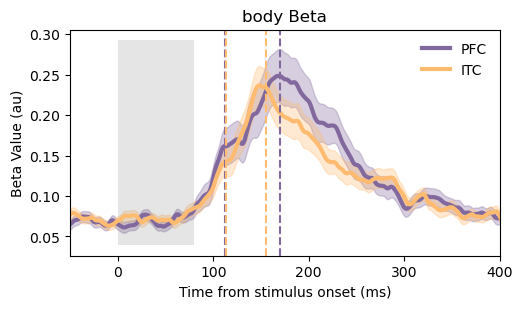

In [185]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.04]
figure_size = np.array((5,3)) * 1

beta_plot_itc = beta_select_itc[~np.isnan(peaksss_itc)]
beta_plot_pfc = beta_select_pfc[~np.isnan(peaksss_pfc)]

m_plot([beta_plot_pfc, beta_plot_itc], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Beta Value (au)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0], plot_ylim[1]])

# plt.savefig(f'{FigDir}reg_beta_{myCond}.svg')

MannwhitneyuResult(statistic=4420.5, pvalue=7.454626616695898e-39)


Text(0.5, 1.0, 'Solution Time')

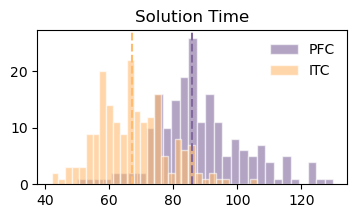

In [186]:
np.random.seed(15)
num_epoch = 200
rand_idx_itc, rand_idx_pfc = [], []
for i_ep in range(num_epoch):
    rand_idx_itc.append(np.random.choice((~np.isnan(peaksss_itc)).sum(),(~np.isnan(peaksss_itc)).sum()))
    rand_idx_pfc.append(np.random.choice((~np.isnan(peaksss_pfc)).sum(),(~np.isnan(peaksss_pfc)).sum()))

rands_itc, rands_pfc = [], []
for i_ep in range(num_epoch):
    rands_itc.append(np.nanmean(beta_plot_itc[rand_idx_itc[i_ep]], axis=0))
    rands_pfc.append(np.nanmean(beta_plot_pfc[rand_idx_pfc[i_ep]], axis=0))

base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(rands_itc, time_stamps, base_time_idx)
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(rands_pfc, time_stamps, base_time_idx)

figure_size=(4,2)

plt.figure(figsize=figure_size)

plot_num = 3
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    # plt.savefig(f'{FigDir}reg_beta_anim_stat.svg')
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(plot_title)

ITC neuron num = 194
PFC neuron num = 194
-----
Onset ITC = 83.0 -+ 8.81
Onset PFC = 82.0 -+ 9.77
Onset Mann-Whitney p = 0.32799749333181294
-----
Peak ITC = 149.0 -+ 5.79
Peak PFC = 170.0 -+ 9.49
Peak Mann-Whitney p = 3.0626477170758235e-56
-----
Solution ITC = 67.0 -+ 11.06
Solution PFC = 86.0 -+ 13.95
Solution Mann-Whitney p = 7.454626616695898e-39


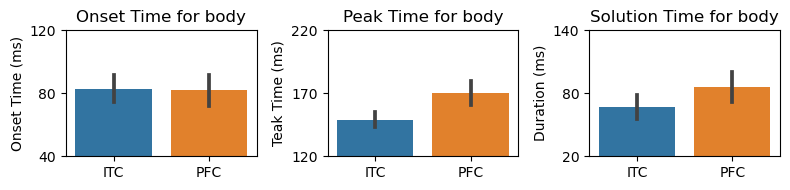

In [189]:
figure_size = np.array((4,1)) * 2
estimator = 'median'
err_method = 'sd'
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)

plt_onset = sns.barplot(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator=estimator, errorbar=err_method)
ax[0].set_ylim([40,120])
ax[0].set_yticks([40,80,120])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator=estimator, errorbar=err_method)
ax[1].set_ylim([120,220])
ax[1].set_yticks([120,170,220])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator=estimator, errorbar=err_method)
ax[2].set_ylim([20,140])
ax[2].set_yticks([20,80,140])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'ITC neuron num = {(~np.isnan(onsetsss_itc)).sum()}')
print(f'PFC neuron num = {(~np.isnan(onsetsss_pfc)).sum()}')
print(f"-----")
print(f'Onset ITC = {np.nanmedian(onsetsss_itc).round(2)} -+ {np.nanstd(onsetsss_itc).round(2)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc).round(2)} -+ {np.nanstd(onsetsss_pfc).round(2)}')
print(f"Onset Mann-Whitney p = {mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc).round(2)} -+ {np.nanstd(peaksss_itc).round(2)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc).round(2)} -+ {np.nanstd(peaksss_pfc).round(2)}')
print(f"Peak Mann-Whitney p = {mnu(peaksss_itc, peaksss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc).round(2)} -+ {np.nanstd(solsss_itc).round(2)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc).round(2)} -+ {np.nanstd(solsss_pfc).round(2)}')
print(f"Solution Mann-Whitney p = {mnu(solsss_itc, solsss_pfc, nan_policy='omit')[1]}")

# plt.savefig(f'{FigDir}reg_beta_{myCond}_stat.svg')

([<matplotlib.axis.YTick at 0x1d00c00b0d0>,
 [Text(0, 0.05, '0.05'), Text(0, 0.3, '0.30')])

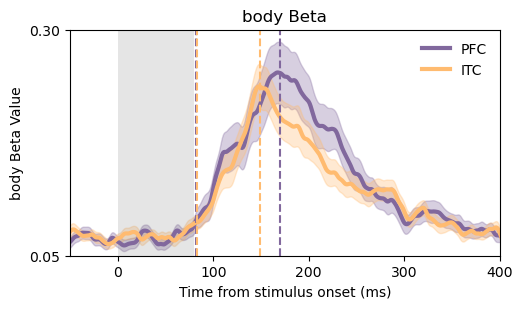

In [191]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [.05,.3]
figure_size = np.array((5,3)) * 1

beta_plot_itc = np.array(rands_itc)[~np.isnan(peaksss_itc)]
beta_plot_pfc = np.array(rands_pfc)[~np.isnan(peaksss_pfc)]

m_plot([beta_plot_pfc, beta_plot_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel(f'{myCond} Beta Value')
plt.ylim(plot_ylim)
plt.yticks(plot_ylim)

# plt.savefig(f'{FigDir}reg_beta_{myCond}.svg')

Text(16.22222222222222, 0.5, 'Beta Value (au)')

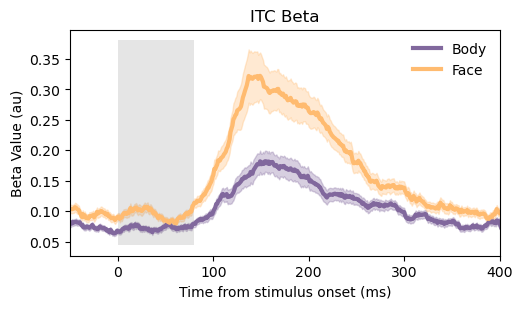

In [62]:
smooth_win = 0
myCond = 'ITC'
beta_num_face = 1
beta_num_body = 2
beta_select_face = smooth(abs(np.array(all_beta_itc[beta_num_face])), sigma=smooth_win, axes=1)
beta_select_body = smooth(abs(np.array(all_beta_itc[beta_num_body])), sigma=smooth_win, axes=1)

plot_xlim = [-50,400]
figure_size=(5,3)

m_plot([beta_select_body, beta_select_face], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, labels=['Body', 'Face'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel(f'Beta Value (au)')

MannwhitneyuResult(statistic=3516.0, pvalue=0.6641257797538995)


Text(0.5, 1.0, 'Peak Time')

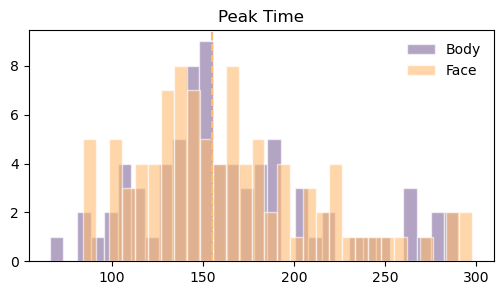

In [117]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_face, onsetsss_face, solsss_face, _ = FindResp(beta_select_face, time_stamps, base_time_idx)
_, peaksss_body, onsetsss_body, solsss_body, _ = FindResp(beta_select_body, time_stamps, base_time_idx)

figure_size=(6,3)

plt.figure(figsize=figure_size)

plot_num = 1
if plot_num==1:
    plt.hist(peaksss_body, bins=30, color=color_pfc_n[:3], alpha=.6, label='Body', edgecolor=[1,1,1])
    plt.hist(peaksss_face, bins=30, color=color_itc_n[:3], alpha=.6, label='Face', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_body), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_face), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(peaksss_face, peaksss_body, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    # plt.savefig(f'{FigDir}reg_beta_anim_stat.svg')
elif plot_num==2:
    plt.hist(onsetsss_body, bins=30, color=color_pfc_n[:3], alpha=.6, label='Body', edgecolor=[1,1,1])
    plt.hist(onsetsss_face, bins=30, color=color_itc_n[:3], alpha=.6, label='Face', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_body), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_face), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(onsetsss_face, onsetsss_body, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_body, bins=30, color=color_pfc_n[:3], alpha=.6, label='Body', edgecolor=[1,1,1])
    plt.hist(solsss_face, bins=30, color=color_itc_n[:3], alpha=.6, label='Face', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_body), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_face), ls='--', color=color_itc_n[:3], alpha=1)

    # print(mnu(solsss_itc[~np.isnan(solsss_itc)], solsss_pfc[~np.isnan(solsss_pfc)]))
    print(mnu(solsss_face, solsss_body, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(plot_title)

Text(25.09722222222222, 0.5, 'Beta Value (au)')

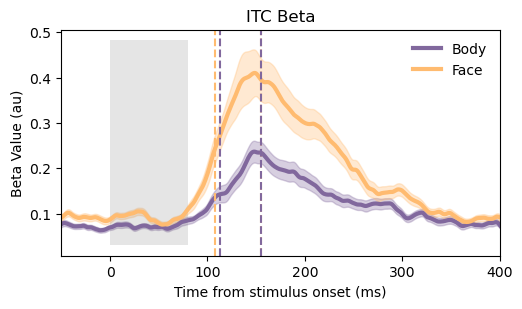

In [118]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.05]
figure_size=(5,3)

beta_plot_face = beta_select_face[~np.isnan(peaksss_face)]
beta_plot_body = beta_select_body[~np.isnan(peaksss_body)]

m_plot([beta_plot_body, beta_plot_face], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, labels=['Body','Face'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.axvline(np.nanmedian(peaksss_face), ls='--', color=color_itc_n[:3], alpha=1)
plt.axvline(np.nanmedian(peaksss_body), ls='--', color=color_pfc_n[:3], alpha=1)

plt.axvline(np.nanmedian(onsetsss_face), ls='--', color=color_itc_n[:3], alpha=1)
plt.axvline(np.nanmedian(onsetsss_body), ls='--', color=color_pfc_n[:3], alpha=1)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Beta Value (au)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0], plot_ylim[1]])

# plt.savefig(f'{FigDir}reg_beta_{myCond}.svg')

# Reg -> Population

In [25]:
all_beta_itc, all_beta_pfc, r2_itc, r2_pfc = [], [], [], []

for iCycle in tqdm(range(cycel_num)):
    tmp_betas_itc, tmp_r2_itc = reg_feat_pop(regressor, resp_itc[idx_rand_itc[iCycle],:,:])
    tmp_betas_pfc, tmp_r2_pfc = reg_feat_pop(regressor, resp_pfc[idx_rand_pfc[iCycle],:,:])

    all_beta_itc.append(tmp_betas_itc)
    r2_itc.append(tmp_r2_itc)
    all_beta_pfc.append(tmp_betas_pfc)
    r2_pfc.append(tmp_r2_pfc)

r2_itc = np.array(r2_itc)
r2_pfc = np.array(r2_pfc)

all_beta_itc = abs(np.array(all_beta_itc))
all_beta_pfc = abs(np.array(all_beta_pfc))

  0%|          | 0/200 [00:00<?, ?it/s]

In [63]:
all_beta_itc, all_beta_pfc = [], []

for iCycle in tqdm(range(cycel_num)):
    all_beta_itc.append(glm_pop(regressor, resp_itc[idx_rand_itc[iCycle],:,:]))
    all_beta_pfc.append(glm_pop(regressor, resp_pfc[idx_rand_pfc[iCycle],:,:]))

all_beta_itc = abs(np.array(all_beta_itc))
all_beta_pfc = abs(np.array(all_beta_pfc))

  0%|          | 0/200 [00:00<?, ?it/s]

In [153]:
all_beta_itc = np.zeros((regressor.shape[1], cycel_num, resp_itc.shape[2])) * np.nan
all_beta_pfc = np.zeros((regressor.shape[1], cycel_num, resp_pfc.shape[2])) * np.nan
all_beta_itc_z, all_beta_pfc_z = np.copy(all_beta_itc),  np.copy(all_beta_pfc)

# cycel_num = 10
for iCycle in tqdm(range(cycel_num)):
    all_beta_itc[:,iCycle,:], all_beta_itc_z[:,iCycle,:] = glm_pop_sig(regressor, resp_itc[idx_rand_itc[iCycle],:,:])
    all_beta_pfc[:,iCycle,:], all_beta_pfc_z[:,iCycle,:] = glm_pop_sig(regressor, resp_pfc[idx_rand_pfc[iCycle],:,:])



  0%|          | 0/10 [00:00<?, ?it/s]

In [154]:
if 0:
       smooth_win = 2
       figure_size = np.array((2,1)) * 2
       plot_xlim = [-50,400]
       beta_num = 0

       m_plot([r2_pfc, r2_itc], [color_pfc,color_itc], error_method='sem',
              smooth_win=smooth_win, labels=['PFC','ITC'], plot_title='Population Regression R2 Score', timepoints=time_stamps, figure_size=figure_size)

       plt.xlim(plot_xlim)
       plt.xticks([0,100,200,300,400])
       plt.xlabel('Time from stimulus onset (ms)')
       plt.ylabel('R2 Score (au)')

Text(0.5, 3.722222222222216, 'Time from stimulus onset (ms)')

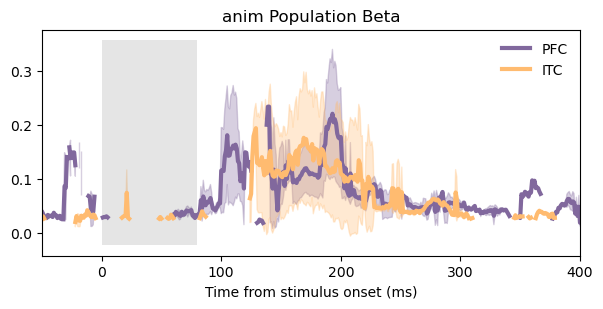

In [167]:
smooth_win = 0
figure_size = np.array((2,1)) * 3
plot_xlim = [-50,400]
beta_num = 0
myCond = conds[beta_num]

beta_select_itc = abs(all_beta_itc[:,beta_num,:])
beta_select_pfc = abs(all_beta_pfc[:,beta_num,:])

m_plot([beta_select_pfc, beta_select_itc], [color_pfc,color_itc], error_method='std',
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Population Beta', timepoints=time_stamps, figure_size=figure_size)

plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])
plt.xlabel('Time from stimulus onset (ms)')

MannwhitneyuResult(statistic=10200.0, pvalue=4.245106316232829e-05)


Text(0.5, 1.0, 'Peak Time')

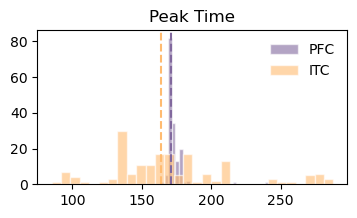

In [70]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(abs(all_beta_itc[:,beta_num,:]), time_stamps, base_time_idx)
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(abs(all_beta_pfc[:,beta_num,:]), time_stamps, base_time_idx)

figure_size = np.array((2,1)) * 2
plt.figure(figsize=figure_size)

plot_num = 1
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(peaksss_itc[~np.isnan(peaksss_itc)], peaksss_pfc[~np.isnan(peaksss_pfc)]))
    plot_ylim = [0,15]
    plot_title = 'Peak Time'
    # plt.savefig(f'{FigDir}reg_beta_anim_stat.svg')
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(onsetsss_itc[~np.isnan(onsetsss_itc)], onsetsss_pfc[~np.isnan(onsetsss_pfc)]))
    plot_ylim = [0,20]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(mnu(solsss_itc[~np.isnan(solsss_itc)], solsss_pfc[~np.isnan(solsss_pfc)]))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(plot_title)



ITC neuron num = 172
PFC neuron num = 160
-----
Onset ITC = 87.0 -+ 34.37
Onset PFC = 78.5 -+ 21.91
Onset Mann-Whitney p = 9.842483840219565e-10
-----
Peak ITC = 164.0 -+ 44.76
Peak PFC = 171.0 -+ 7.09
Peak Mann-Whitney p = 4.245106316232829e-05
-----
Solution ITC = 61.0 -+ 49.16
Solution PFC = 95.5 -+ 21.28
Solution Mann-Whitney p = 9.917228621402918e-12


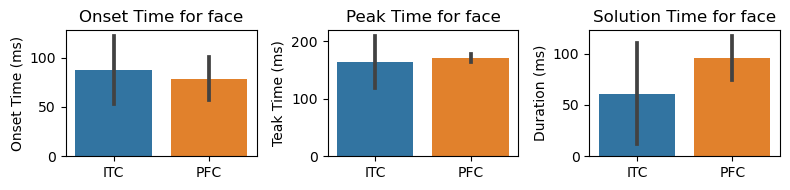

In [71]:
figure_size = np.array((4,1)) * 2
estimator = 'median'
err_method = 'sd'
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)

plt_onset = sns.barplot(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator=estimator, errorbar=err_method)
# ax[0].set_ylim([90,130])
# ax[0].set_yticks([90,110,130])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator=estimator, errorbar=err_method)
# ax[1].set_ylim([140,200])
# ax[1].set_yticks([140,160,180,200])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator=estimator, errorbar=err_method)
# ax[2].set_ylim([0,80])
# ax[2].set_yticks([0,40,80])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'ITC neuron num = {(~np.isnan(onsetsss_itc)).sum()}')
print(f'PFC neuron num = {(~np.isnan(onsetsss_pfc)).sum()}')
print(f"-----")
print(f'Onset ITC = {np.nanmedian(onsetsss_itc).round(2)} -+ {np.nanstd(onsetsss_itc).round(2)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc).round(2)} -+ {np.nanstd(onsetsss_pfc).round(2)}')
print(f"Onset Mann-Whitney p = {mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc).round(2)} -+ {np.nanstd(peaksss_itc).round(2)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc).round(2)} -+ {np.nanstd(peaksss_pfc).round(2)}')
print(f"Peak Mann-Whitney p = {mnu(peaksss_itc, peaksss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc).round(2)} -+ {np.nanstd(solsss_itc).round(2)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc).round(2)} -+ {np.nanstd(solsss_pfc).round(2)}')
print(f"Solution Mann-Whitney p = {mnu(solsss_itc, solsss_pfc, nan_policy='omit')[1]}")

# plt.savefig(f'{FigDir}reg_beta_{myCond}_stat.svg')

Text(16.22222222222222, 0.5, 'Beta Value (au)')

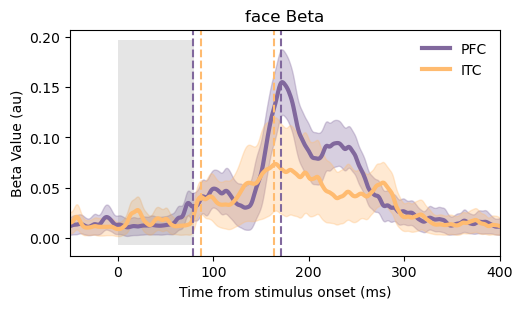

In [72]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.04]
figure_size = np.array((5,3)) * 1

beta_plot_itc = beta_select_itc[~np.isnan(peaksss_itc)]
beta_plot_pfc = beta_select_pfc[~np.isnan(peaksss_pfc)]

m_plot([beta_plot_pfc, beta_plot_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} Beta', timepoints=time_stamps, figure_size=figure_size)

plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Beta Value (au)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0], plot_ylim[1]])

# plt.savefig(f'{FigDir}reg_beta_{myCond}.svg')